# GNNExplainer
replaced by one seed (average runs only make sense if GNNExplainer finds one clear solution, however, this was not the case for stations in the flatter regions
new version: gnnexplainer_oneseed

In [1]:
%cd /home/ltchen/gnnpp
import sys
import json
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx
from exploration.get_graphs_and_data import *
from utils.explainability_utils import *
from utils.plot import plot_map

/home/ltchen/gnnpp


In [2]:
DIRECTORY = os.getcwd()
print(DIRECTORY)
FIGUREPATH = os.path.join(DIRECTORY, 'figures/results/gnnexplainer')
os.makedirs(FIGUREPATH, exist_ok=True)

/home/ltchen/gnnpp


In [3]:
leadtime = "72h"
graph_name = "g1"

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
DIRECTORY = os.getcwd()

JSONPATH, SAVEPATH, RESULTPATH = get_json_save_result_paths(leadtime=leadtime, graph_name=graph_name)
with open(JSONPATH, "r") as f:
    print(f"[INFO] Loading {JSONPATH}")
    args_dict = json.load(f)
config = args_dict

g_train_rf, g_valid_rf, g_test_rf, g_test_f = get_train_valid_graph_data(leadtime=leadtime, graph_name=graph_name)

g1_train_loader = DataLoader(g_train_rf, batch_size=config['batch_size'], shuffle=True)
g1_valid_loader = DataLoader(g_valid_rf, batch_size=config['batch_size'], shuffle=True)
g1_test_f_loader = DataLoader(g_test_f, batch_size=config['batch_size'], shuffle=False)
g1_test_rf_loader = DataLoader(g_test_rf, batch_size=config['batch_size'], shuffle=False)

train_loader = g1_train_loader
valid_loader = g1_valid_loader
test_f_loader = g1_test_f_loader
test_rf_loader = g1_test_rf_loader
test_loader = [test_f_loader, test_rf_loader]

emb_dim = 20
in_channels = g_train_rf[0].x.shape[1] + emb_dim - 1
edge_dim = g_train_rf[0].num_edge_features
num_nodes = g_train_rf[0].num_nodes

[INFO] Loading /home/ltchen/gnnpp/leas_trained_models/sum_stats_72h/g1_72h/params.json
[INFO] Loading precomputed graph data on g1...


/tmp/pycharm_project_408/exploration/get_graphs_and_data.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(train_path)
/tmp/pycharm_project_408/ex

Successfully loaded precomputed data.


In [4]:
d = "test_f"
TRAINNAME = f"{graph_name}_{leadtime}_train_run0"
CKPT_PATH = os.path.join(SAVEPATH, TRAINNAME + '.ckpt')
multigraph = load_gnn_model(CKPT_PATH, num_nodes, emb_dim, edge_dim, in_channels, config)

if d == "train":
    graph_to_explain = g_train_rf[0]
if d == "test_rf":
    graph_to_explain = g_test_rf[0]
if d == "test_f":
    graph_to_explain = g_test_f[0]

multigraph = multigraph.to('cpu')
graph_to_explain = graph_to_explain.to('cpu')
node_idx = 118 # 23 #5: g1: lr=0.04, es=0.03; g5: lr=0.04, edge_size=0.2, g4: 1000 epochs: lr=0.01, edge_size=0.005
degrees = degree(graph_to_explain.edge_index[0])
num_neighbors = degrees[node_idx].item()
print(f"Node {node_idx} has {num_neighbors} neighbors")

Node 118 has 4.0 neighbors


### Inspect GNNExplainer for loss function

In [26]:
import inspect
from torch_geometric.explain import Explainer, GNNExplainer

source = inspect.getsource(GNNExplainer)
print(inspect.getfile(GNNExplainer))
print(source)
print(GNNExplainer.__mro__)

/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/torch_geometric/explain/algorithm/gnn_explainer.py
class GNNExplainer(ExplainerAlgorithm):
    r"""The GNN-Explainer model from the `"GNNExplainer: Generating
    Explanations for Graph Neural Networks"
    <https://arxiv.org/abs/1903.03894>`_ paper for identifying compact subgraph
    structures and node features that play a crucial role in the predictions
    made by a GNN.

    .. note::

        For an example of using :class:`GNNExplainer`, see
        `examples/explain/gnn_explainer.py <https://github.com/pyg-team/
        pytorch_geometric/blob/master/examples/explain/gnn_explainer.py>`_,
        `examples/explain/gnn_explainer_ba_shapes.py <https://github.com/
        pyg-team/pytorch_geometric/blob/master/examples/
        explain/gnn_explainer_ba_shapes.py>`_, and `examples/explain/
        gnn_explainer_link_pred.py <https://github.com/pyg-team/
        pytorch_geometric/blob/master/examples/explain/gnn_explainer

In [17]:
import inspect
from torch_geometric.explain import ExplainerAlgorithm, GNNExplainer

source = inspect.getsource(Explainer)
print(inspect.getfile(ExplainerAlgorithm))
print(source)

/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/torch_geometric/explain/algorithm/base.py
class Explainer:
    r"""An explainer class for instance-level explanations of Graph Neural
    Networks.

    Args:
        model (torch.nn.Module): The model to explain.
        algorithm (ExplainerAlgorithm): The explanation algorithm.
        explanation_type (ExplanationType or str): The type of explanation to
            compute. The possible values are:

                - :obj:`"model"`: Explains the model prediction.

                - :obj:`"phenomenon"`: Explains the phenomenon that the model
                  is trying to predict.

            In practice, this means that the explanation algorithm will either
            compute their losses with respect to the model output
            (:obj:`"model"`) or the target output (:obj:`"phenomenon"`).
        model_config (ModelConfig): The model configuration.
            See :class:`~torch_geometric.explain.config.ModelConfig

In [10]:
from torch.nn import functional as F
F.mse_loss(torch.tensor([[3.3259, 0.9958]]), torch.tensor([[6.6966, 1.3058]])) # mu, sigma

tensor(5.7289)

In [11]:
mexplainer = create_explainer(multigraph, epochs=300, lr=0.02) #
explanation = mexplainer(x=graph_to_explain.x, edge_index=graph_to_explain.edge_index,
                         edge_attr=graph_to_explain.edge_attr, index=node_idx)
print(f'Generated explanations in {explanation.available_explanations}')
loss = mexplainer.algorithm._loss(torch.tensor([[3.3259, 0.9958]]), torch.tensor([[6.6966, 1.3058]])) # could define a self.last_loss inside the loss functian of GNNExplainer and then retrieve the last loss and compare it for the different hyperparameters?
loss

Generated explanations in ['node_mask', 'edge_mask']


tensor(3.3934)

In [35]:
import torch
import torch.distributions as dist

y_hat = torch.tensor([[3.3259, 0.9958]])
y = torch.tensor([[6.6966, 1.3058]])


p = dist.Normal(y[0, 0], y[0, 1])
# p1 = torch.normal(y[0, 0], y[0, 1])
q = dist.Normal(y_hat[0, 0], y_hat[0,1])
# q1 = torch.normal(y_hat[0, 0], y_hat[0,1])
print(p)
# print(p1)
kl_loss = torch.distributions.kl.kl_divergence(q, p)
# nn.KLDivLoss(reduction="batchmean")
kl_loss


Normal(loc: 6.696599960327148, scale: 1.305799961090088)


tensor(3.3934)

### Continuing after fixing loss

In [5]:
# feature mask
df = pd.DataFrame(columns=['run_id', 'node', 'feature', 'weight'])
weights_dict = {}
num_runs = 5

for run_id in range(num_runs):
    mexplainer = create_explainer(multigraph, epochs=1000, lr=0.04, edge_size = 0.03) # lr= 0.04, edge_size = 0.03
    explanation = mexplainer(x=graph_to_explain.x, edge_index=graph_to_explain.edge_index,
                             edge_attr=graph_to_explain.edge_attr, index=node_idx)
    print(f'Generated explanations in {explanation.available_explanations}')

# Feature importance ################################################################
    feature_loc = torch.nonzero(explanation.node_mask,
                                as_tuple=False)  # feature_loc.shape = 384 (64*6), 2 (node, feature)
    # feature_tuples = [tuple(row.tolist()) for row in feature_loc]
    node_weights = explanation.node_mask[explanation.node_mask != 0]

    # print(node_weights.shape)
    if run_id == 0:
        df = pd.DataFrame({
            'node': feature_loc[:, 0].numpy(),
            'feature': feature_loc[:, 1].numpy(),
            f'weight_{run_id}': node_weights.numpy()
        })
    else:
        df[f'weight_{run_id}'] = node_weights.numpy()
    # df = pd.concat([df, new_df], ignore_index=True) # would add a row, but we want columns

# Neighboring node importance (edge masks) ######################################################################
    mask_idx = np.where(explanation.edge_mask > 0)[0]
    edge_weights = explanation.edge_mask[mask_idx]
    edge_idx = explanation.edge_index[:, mask_idx].squeeze(1)
    transposed = edge_idx.transpose(0, 1)

    #print(transposed.shape)
    tuples = [tuple(row.tolist()) for row in transposed]

    for i in range(len(tuples)):
        weight = edge_weights[i].item()
        key = tuples[i]
        if key in weights_dict:
            weights_dict[key].append(weight)
        else:
            weights_dict[key] = [weight]
    #print(weights_dict)
mean_weights = {edge: sum(weights)/len(weights) for edge, weights in weights_dict.items()}
print(mean_weights)
print(df)

Generated explanations in ['node_mask', 'edge_mask']


KeyboardInterrupt: 

In [37]:
run_list = [f"weight_{run_id}" for run_id in range(num_runs)]
feature_names, grouped = get_feature_list()
# len(grouped)


In [63]:
mode = 'single'
i = 12
if mode == 'single':
    if i == node_idx:
        TITLE = f"Feature importance of node {i}\n"
    else:
        TITLE = f"Feature importance of node {i} \nin neighborhood of node {node_idx}"
    sort_i = df[df['node']==i]
    sort_i['weight_mean'] = sort_i[run_list].mean(axis=1)
    sort_i = sort_i.sort_values(by='weight_mean', ascending=False)
elif mode == 'all':
    sort_i = df.groupby('feature').mean()
    # print(sort_i)
    sort_i['weight_mean'] = sort_i[run_list].mean(axis=1)
    sort_i = sort_i.sort_values(by='weight_mean', ascending=False)
    TITLE = f"Feature importance of all nodes \nin neighborhood of node {node_idx}"
else:
    print("Not a valid input.")

sort_i = sort_i.reset_index()
sort_i['feature_name'] = sort_i['feature'].apply(lambda i: feature_names[i])
sort_i

/tmp/ipykernel_496464/3494075983.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sort_i['weight_mean'] = sort_i[run_list].mean(axis=1)


,index,node,feature,weight_0,weight_1,weight_2,weight_3,weight_4,weight_mean,feature_name
0,698,12,59,0.001725,0.002058,0.003835,0.001526,0.002550,0.002339,v_mean
1,660,12,21,0.001405,0.001150,0.004086,0.001562,0.001990,0.002038,u10_mean
2,680,12,41,0.002303,0.001429,0.002423,0.002294,0.001727,0.002035,sshf6_mean
3,648,12,9,0.001225,0.001802,0.002938,0.001172,0.002114,0.001850,stl1_mean
4,672,12,33,0.001461,0.001702,0.002747,0.001200,0.001796,0.001781,mn2t6_mean
...,...,...,...,...,...,...,...,...,...,...
59,647,12,8,0.001003,0.001014,0.000948,0.001048,0.000974,0.000997,sd_std
60,684,12,45,0.000913,0.001032,0.001056,0.000951,0.001022,0.000995,ssrd6_mean
61,682,12,43,0.001015,0.001045,0.000987,0.000978,0.000877,0.000981,ssr6_mean
62,646,12,7,0.001055,0.000960,0.000815,0.001008,0.000972,0.000962,sd_mean


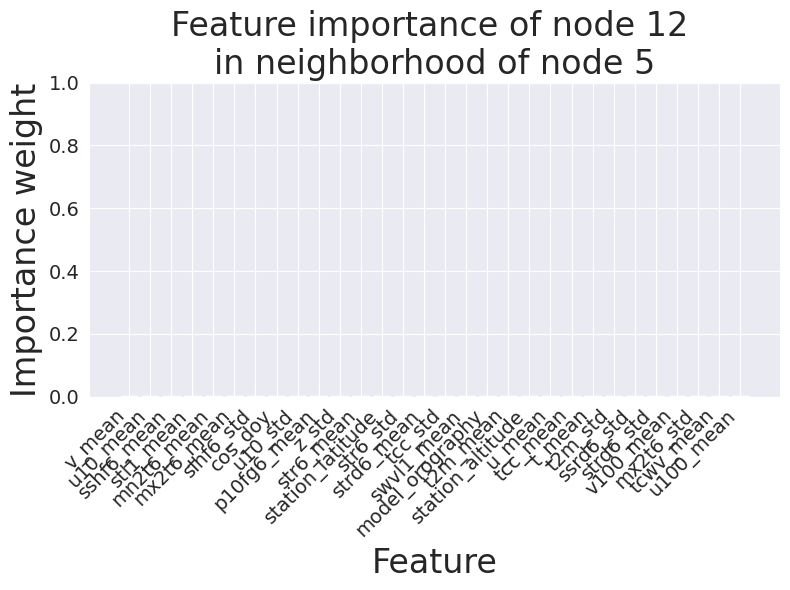

In [64]:
temperature_features = ['t2m_mean', 't2m_std', 'mn2t6_mean', 'mn2t6_std', 'mx2t6_mean', 'mx2t6_std']
alt_orog = ['station_altitude', 'model_orography']
# colors = ['orange' if feature in temperature_features else 'skyblue' for feature in sort_i['feature_name']]
colors = [
    'orange' if feature in temperature_features else
    'gray' if feature in alt_orog else
    'skyblue'
    for feature in sort_i['feature_name']
]
plt.figure(figsize=(8, 6))
plt.bar(sort_i['feature_name'][:30], sort_i['weight_mean'][:30], color=colors)
# plt.bar(sort_i['feature_name'], sort_i['weight_mean'], color=colors)
plt.xlabel('Feature', fontsize=24)
plt.ylabel('Importance weight', fontsize=24)
plt.ylim([0, 1])
plt.title(TITLE, fontsize=24)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)
# plt.grid(axis='y')
plt.tight_layout()
# plt.savefig(os.path.join(FIGUREPATH, f"gnnx_features_{graph_name}_{mode}_{node_idx}-{i}_{leadtime}_{d}.pdf"), format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
dataframes = load_dataframes(leadtime)
dataframes = summary_statistics(dataframes)
dataframes['stations']

[INFO] Dataframes exist. Will load pandas dataframes.
[INFO] Calculating summary statistics for train
[INFO] Calculating summary statistics for valid
[INFO] Calculating summary statistics for test_rf
[INFO] Calculating summary statistics for test_f


,station_id,lat,lon,altitude,orog,name
0,0,52.928000,4.781000,1.2,-1.706008,De Kooy
1,1,52.318000,4.790000,-3.3,-1.298122,Schiphol
2,2,53.241000,4.921000,10.8,0.333424,Vlieland
3,3,53.392000,5.346000,0.7,1.302155,Hoorn (Terschelling)
4,4,52.100000,5.180000,1.9,2.576800,De Bilt
...,...,...,...,...,...,...
115,115,45.786833,3.149333,331.0,521.714299,Clermont-Fd
116,116,47.499168,9.746111,424.0,689.253673,Bregenz
117,117,47.266666,9.600000,439.0,972.938723,Feldkirch
118,118,47.255833,10.186111,1478.0,1752.460782,Warth


In [11]:
# retrieve position from dataframes['stations']
pos_dict = {row['station_id']: (row['lon'], row['lat']) for _, row in dataframes['stations'].iterrows()}
alt_dict = {row['station_id']: row['altitude'] for _, row in dataframes['stations'].iterrows()}
node_list = df['node'].unique().tolist()
this_alt_dict = {node: alt_dict[node] for node in node_list if node in alt_dict}
lons = [pos_dict[node][0] for node in node_list if node in pos_dict]
lats = [pos_dict[node][1] for node in node_list if node in pos_dict]
lats
# this_alt_dict

[52.928,
 53.241,
 53.392,
 52.1,
 52.898,
 52.458,
 53.224,
 52.703,
 53.413,
 52.435,
 52.75]

<Figure size 1200x1200 with 0 Axes>

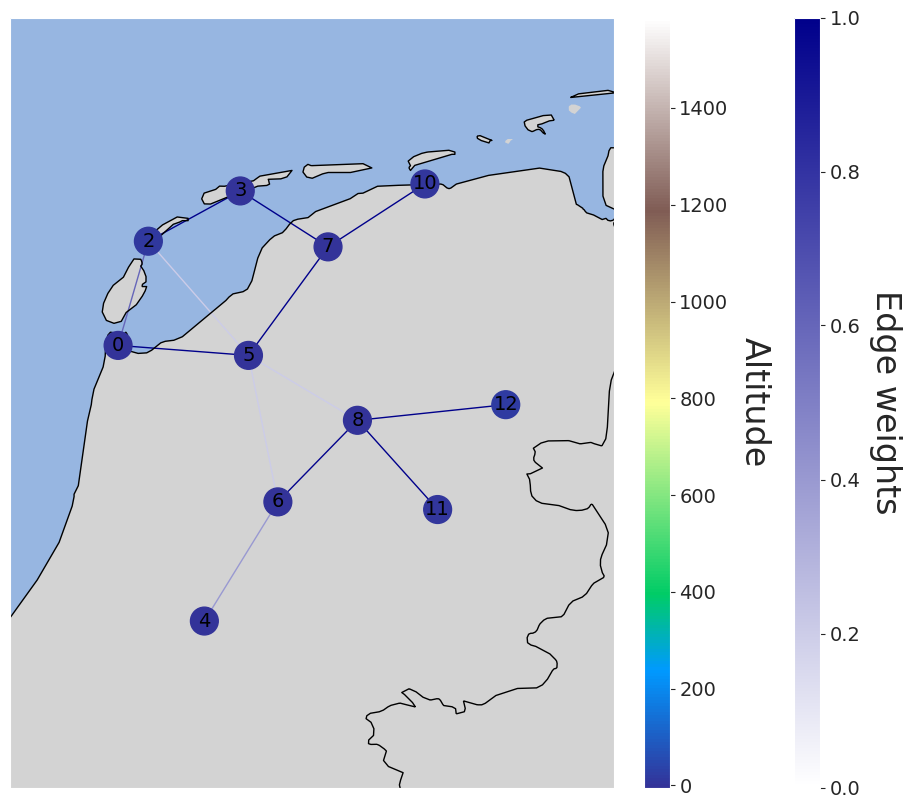

In [12]:
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

import cartopy.crs as ccrs
subG = nx.Graph()

for (u, v), weight in mean_weights.items():
    subG.add_edge(u, v, weight=weight)

edges = list(mean_weights.keys())
weights = list(mean_weights.values())

fig = plt.figure(figsize=(12, 12))
ax = plot_map()

cmap_alt = cm.terrain
cmap_edge = LinearSegmentedColormap.from_list("white_to_blue", ["white", "darkblue"])

norm_edge = plt.Normalize(0, 1)
norm_alt = plt.Normalize(vmin=min(dataframes['stations']['altitude']), vmax=max(dataframes['stations']['altitude']))
edge_colors = [cmap_edge(norm_edge(w)) for w in weights]
node_colors = [cmap_alt(norm_alt(a)) for a in this_alt_dict.values()]

proj = ccrs.PlateCarree()
margin = 0.5
lon_min, lon_max = min(lons) - margin, max(lons) + margin
lat_min, lat_max = min(lats) - margin, max(lats) + margin

ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
# ax.set_extent([2, 8, 50, 54], crs=proj)

sm_nodes = plt.cm.ScalarMappable(cmap=cmap_alt, norm=norm_alt)
sm_edges = plt.cm.ScalarMappable(cmap=cmap_edge, norm=norm_edge)

colbar2 = plt.colorbar(sm_edges, ax=ax, aspect=30, pad=0.04)
colbar1 = plt.colorbar(sm_nodes, ax=ax, aspect=30, pad=0.04)

colbar2.ax.set_ylabel("Edge weights", rotation=270, labelpad=30, fontsize=24)
colbar2.ax.tick_params(labelsize=14)
colbar1.ax.set_ylabel("Altitude", rotation=270, labelpad=30, fontsize=24)
colbar1.ax.tick_params(labelsize=14)


nx.draw_networkx(subG, pos_dict, node_size=400, node_color=node_colors, ax=ax, edge_color=edge_colors, with_labels=False)
nx.draw_networkx_labels(subG, pos_dict, font_size=14)
plt.savefig(os.path.join(FIGUREPATH, f"gnnx_map_{graph_name}_{node_idx}_{leadtime}_{d}.pdf"), format='pdf', dpi=300, bbox_inches='tight')


In [67]:
from pprint import pprint
pprint(dataframes['stations'][dataframes['stations']['station_id'] == 23])
pprint(dataframes['stations'][dataframes['stations']['station_id'] == 25])
pprint(dataframes['stations'][dataframes['stations']['station_id'] == 4])
pprint(dataframes['stations'][dataframes['stations']['station_id'] == 76])

    station_id    lat    lon  altitude      orog    name
23          23  51.97  4.926      -0.7 -0.941221  Cabauw
    station_id     lat    lon  altitude      orog       name
25          25  51.859  5.146       0.7  1.506098  Herwijnen
   station_id   lat   lon  altitude    orog     name
4           4  52.1  5.18       1.9  2.5768  De Bilt
    station_id      lat     lon  altitude      orog   name
76          76  53.3881  7.2287     -0.27 -0.074462  Emden


### Previous study

In [ ]:
edges = list(subG.edges())
# print(edges)
edge_colors = []
edge_widths = []

edge_importance = {}
# for i, (src, tgt) in enumerate(graph_to_explain.edge_index.t().tolist()):
#     if edge_mask[i] != 0:
#         edge_importance[(src, tgt)] = edge_mask[i]
#         edge_importance[(tgt, src)] = edge_mask[i]

for edge in edges:
    # print(edge)
    importance = edge_importance.get(edge, 0)
    print(importance)
    if importance > 0:
        edge_colors.append(importance)
        edge_widths.append(1 + 4 * importance)
    else:
        edge_colors.append(0.1)
        edge_widths.append(0.5)

In [ ]:
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subG, seed=42)
nx.draw_networkx_edges(
    subG, pos,
    width=edge_widths,
    edge_color=edge_colors,
    edge_cmap=plt.cm.plasma,
    alpha=0.7
)

node_colors = ['red' if n == node_idx else 'skyblue' for n in subG.nodes()]
node_sizes = [300 if n == node_idx else 100 for n in subG.nodes()]

nx.draw_networkx_nodes(
    subgraph, pos,
    nodelist=list(subgraph.nodes()),
    node_color=node_colors,
    node_size=node_sizes
)

nx.draw_networkx_labels(subgraph, pos, font_size=10)

plt.axis('off')
plt.title(f'Explanation for Node {node_idx}')
plt.tight_layout()
plt.show()

Node 25 has 6.0 neighbors


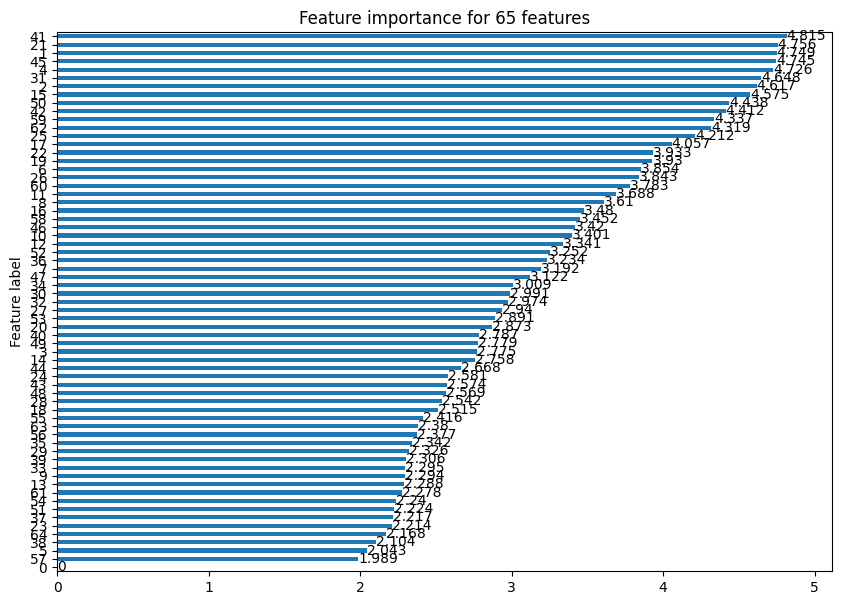

In [61]:
degrees = degree(graph_to_explain.edge_index[0])
num_neighbors = degrees[node_idx].item()
print(f"Node {node_idx} has {num_neighbors} neighbors")
explanation.visualize_feature_importance()
feature_names, grouped = get_feature_list(mode="gnnexplainer")

In [8]:
print(feature_names[61], feature_names[9], feature_names[23], feature_names[13], feature_names[61])

v_std sd_std u10_std swvl1_std v_std


## Old version

In [20]:
dataframes = load_dataframes(leadtime=leadtime)
dataframes = summary_statistics(dataframes)

[INFO] Dataframes exist. Will load pandas dataframes.
[INFO] Calculating summary statistics for train
[INFO] Calculating summary statistics for valid
[INFO] Calculating summary statistics for test_rf
[INFO] Calculating summary statistics for test_f


In [22]:
feature_names = [f for f in dataframes['test_f'][0].columns.tolist()]  # if f not in ['time', 'number']]
len(feature_names)
# feature_names

65

In [4]:
graph_name = "g1"
drn = False
if drn == True:
    SAVEPATH = os.path.join(DIRECTORY, f"leas_trained_models/drn_{leadtime}/models")
    JSONPATH = os.path.join(DIRECTORY, f"trained_models/drn_{leadtime}/params.json")
else:
    SAVEPATH = os.path.join(DIRECTORY, f"leas_trained_models/sum_stats_{leadtime}/{graph_name}_{leadtime}/models")
    JSONPATH = os.path.join(DIRECTORY, f"leas_trained_models/sum_stats_{leadtime}/{graph_name}_{leadtime}/params.json")

with open(JSONPATH, "r") as f:
    print(f"[INFO] Loading {JSONPATH}")
    args_dict = json.load(f)
config = args_dict

[INFO] Loading /home/ltchen/gnnpp/leas_trained_models/sum_stats_24h/g1_24h/params.json


In [5]:
graphs1_train_rf, tests1 = normalize_features_and_create_graphs1(df_train=dataframes['train'],
                                                                 df_valid_test=[dataframes['valid'],
                                                                                dataframes['test_rf'],
                                                                                dataframes['test_f']],
                                                                 station_df=dataframes['stations'], attributes=["geo"],
                                                                 edges=[("geo", 50)], sum_stats=True)
graphs1_valid_rf, graphs1_test_rf, graphs1_test_f = tests1

g1_train_loader = DataLoader(graphs1_train_rf, batch_size=config['batch_size'], shuffle=True)
g1_valid_loader = DataLoader(graphs1_valid_rf, batch_size=config['batch_size'], shuffle=True)
g1_test_f_loader = DataLoader(graphs1_test_f, batch_size=config['batch_size'], shuffle=False)
g1_test_rf_loader = DataLoader(graphs1_test_rf, batch_size=config['batch_size'], shuffle=False)

train_loader = g1_train_loader
valid_loader = g1_valid_loader
test_f_loader = g1_test_f_loader
test_rf_loader = g1_test_rf_loader
test_loader = [test_f_loader, test_rf_loader]

emb_dim = 20
in_channels = graphs1_train_rf[0].x.shape[1] + emb_dim - 1
edge_dim = graphs1_train_rf[0].num_edge_features
# max_epochs = max_epoch_list[graph_name]
num_nodes = graphs1_train_rf[0].num_nodes

[INFO] Normalizing features...
fit_transform
transform 1
transform 2
transform 3


100%|██████████| 730/730 [00:02<00:00, 254.51it/s]


In [6]:
TRAINNAME = f"{graph_name}_{leadtime}_train_run7"
CKPT_PATH = os.path.join(SAVEPATH, TRAINNAME + '.ckpt')
# RESULTPATH = os.path.join(DIRECTORY, f"leas_trained_models/best_{leadtime}/best_{leadtime}_{graph_name}")
RESULTPATH = JSONPATH = os.path.join(DIRECTORY, f"leas_trained_models/sum_stats_{leadtime}/{graph_name}_{leadtime}")
print(RESULTPATH)

multigraph = Multigraph.load_from_checkpoint(
    CKPT_PATH,
    num_nodes=num_nodes,
    embedding_dim=emb_dim,
    edge_dim=edge_dim,
    in_channels=in_channels,
    hidden_channels_gnn=config['gnn_hidden'],
    out_channels_gnn=config['gnn_hidden'],
    num_layers_gnn=config['gnn_layers'],
    heads=config['heads'],
    hidden_channels_deepset=config['gnn_hidden'],
    optimizer_class=AdamW,
    optimizer_params=dict(lr=config['lr']),
)
multigraph.eval()
# trainer = L.Trainer(log_every_n_steps=1, accelerator="gpu", devices=1, enable_progress_bar=True)

/home/ltchen/gnnpp/leas_trained_models/sum_stats_24h/g1_24h


Multigraph(
  (encoder): EmbedStations(
    (embed): Embedding(120, 20)
  )
  (conv): ResGnn(
    (convolutions): ModuleList(
      (0): GATv2Conv(-1, 256, heads=8)
    )
    (lin): Linear(in_features=2048, out_features=256, bias=True)
    (relu): ReLU()
  )
  (aggr): DeepSetAggregator(
    (input): Linear(in_features=256, out_features=256, bias=True)
    (hidden1): Linear(in_features=256, out_features=256, bias=True)
    (hidden2): Linear(in_features=256, out_features=256, bias=True)
    (output): Linear(in_features=256, out_features=2, bias=True)
    (relu): ReLU()
  )
  (postprocess): MakePositive()
  (loss_fn): NormalCRPS()
)

In [7]:
graph_to_explain = graphs1_train_rf[0]

In [8]:
class MultigraphWrapper(nn.Module):
    def __init__(self, model):
        super(MultigraphWrapper, self).__init__()
        self.model = model
        self.training = model.training
        self.device = next(model.parameters()).device
        self.edge_dim = getattr(model, 'edge_dim', 1)
        # print(self.device)

    def forward(self, x, edge_index, edge_attr=None, **kwargs):
        x = x.to(self.device)
        edge_index = edge_index.to(self.device)
        edge_attr = edge_attr.to(self.device)
        # print(f"x.shape: {x.shape}, device: {x.device}")
        # print(f"edge_index.shape: {edge_index.shape}, device: {edge_index.device}")
        # print(f"edge_attr.shape: {edge_attr.shape}, device: {edge_attr.device}")
        data = Data(
            x=x,
            edge_index=edge_index,
            edge_attr=edge_attr,
        )
        data.batch = torch.zeros(x.size(0), dtype=torch.long, device=self.device)
        data.n_idx = torch.arange(x.size(0), device=self.device)
        return self.model(data)

In [22]:
def create_explainer(model):
    # print(model)
    wrapped_model = MultigraphWrapper(model)
    explainer = Explainer(
        model=wrapped_model,
        algorithm=GNNExplainer(epochs=500, lr=0.002),
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config=ModelConfig(
            mode='regression',
            task_level='node',
            return_type='raw'  # crps? globale wichtigkeit
        )
    )
    return explainer

In [30]:
from torch_geometric.utils import degree

multigraph = multigraph.to('cpu')
graph_to_explain = graph_to_explain.to('cpu')
mexplainer = create_explainer(multigraph)
node_idx = 10  # 10
explanation = mexplainer(x=graph_to_explain.x, edge_index=graph_to_explain.edge_index,
                         edge_attr=graph_to_explain.edge_attr, index=node_idx)
print(f'Generated explanations in {explanation.available_explanations}')

degrees = degree(graph_to_explain.edge_index[0])
num_neighbors = degrees[node_idx].item()
print(f"Node {node_idx} has {num_neighbors} neighbors")

Generated explanations in ['edge_mask', 'node_mask']
Node 10 has 2.0 neighbors


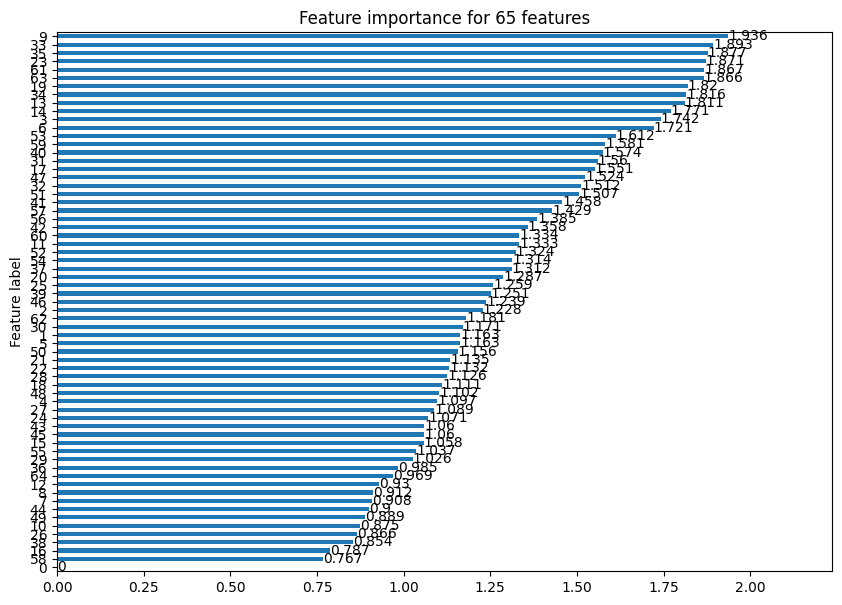

t2m_mean station_latitude mx2t6_mean u100_mean t_mean


In [37]:
explanation.visualize_feature_importance()
feature_names = [f for f in dataframes['test_f'][0].columns.tolist() if
                 f not in ['time', 'number']]  # dropped time and number: len - 65
print(feature_names[13], feature_names[3], feature_names[35], feature_names[23], feature_names[61])

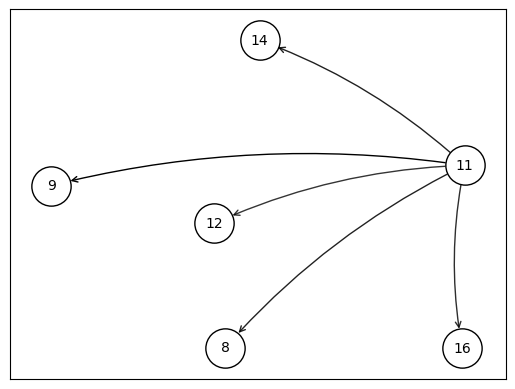

In [18]:
explanation.visualize_graph()
# is station actually only connected to stations 13 and 7?

In [32]:
node_feat_mask = explanation.node_mask.detach().cpu().numpy()
edge_mask = explanation.edge_mask.detach().cpu().numpy()

G = to_networkx(graph_to_explain, to_undirected=True)
nodes = set([node_idx])
neighbors = set(G.neighbors(node_idx))
print(neighbors)
print(nodes)

{13, 7}
{10}


In [33]:
nodes.update(neighbors)
# get neighbors of neighbors
for n in neighbors:
    nodes.update(G.neighbors(n))
print(nodes)
print(neighbors)

subgraph = G.subgraph(nodes)

{3, 5, 7, 10, 12, 13, 15}
{13, 7}


In [34]:
edges = list(subgraph.edges())
# print(edges)
edge_colors = []
edge_widths = []

edge_importance = {}
for i, (src, tgt) in enumerate(graph_to_explain.edge_index.t().tolist()):
    if edge_mask[i] != 0:
        edge_importance[(src, tgt)] = edge_mask[i]
        edge_importance[(tgt, src)] = edge_mask[i]

for edge in edges:
    # print(edge)
    importance = edge_importance.get(edge, 0)
    print(importance)
    if importance > 0:
        edge_colors.append(importance)
        edge_widths.append(1 + 4 * importance)
    else:
        edge_colors.append(0.1)
        edge_widths.append(0.5)

0
0
0.3410892
0.28107765
0
0


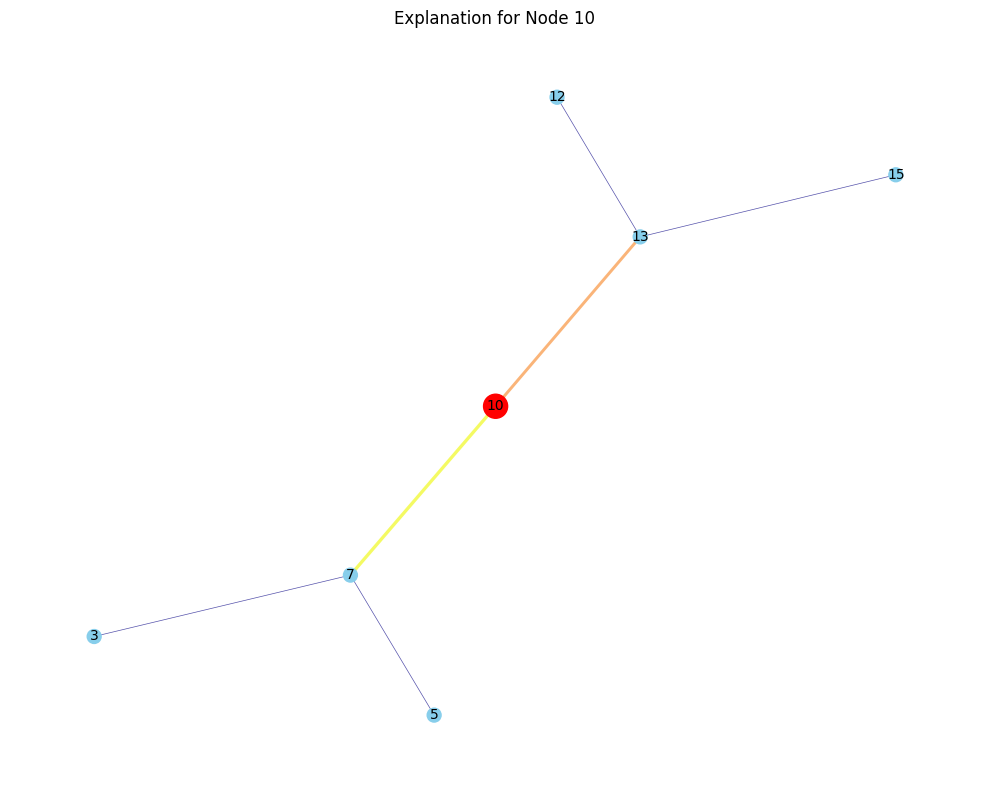

In [35]:
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subgraph, seed=42)
nx.draw_networkx_edges(
    subgraph, pos,
    width=edge_widths,
    edge_color=edge_colors,
    edge_cmap=plt.cm.plasma,
    alpha=0.7
)

node_colors = ['red' if n == node_idx else 'skyblue' for n in subgraph.nodes()]
node_sizes = [300 if n == node_idx else 100 for n in subgraph.nodes()]

nx.draw_networkx_nodes(
    subgraph, pos,
    nodelist=list(subgraph.nodes()),
    node_color=node_colors,
    node_size=node_sizes
)

nx.draw_networkx_labels(subgraph, pos, font_size=10)

plt.axis('off')
plt.title(f'Explanation for Node {node_idx}')
plt.tight_layout()
plt.show()

# auf die Karte plotten
# welche Kanten überhaupt wichtig